# GLM for gravitational wave events
In this notebook, we illustrate through example how to construct a GLM for gravitational wave events. We take GW190521 as an example.

## Imports

In [1]:
# General
import numpy as np
from scipy.interpolate import interp1d
from scipy.linalg import block_diag
import matplotlib.pyplot as plt

# gwpy
from gwpy.timeseries import TimeSeries

# gwosc
from gwosc.datasets import event_gps

# Bilby
import bilby
from gwpy.timeseries import TimeSeries
from bilby.gw.waveform_generator import WaveformGenerator
from bilby.gw.detector import Interferometer

/home/stan/Documents/python_envs/genova/lib/python3.12/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


### Prepare the data

In [2]:
# Define GPS time window
gps_time = event_gps("GW190521")
duration = 4
start = gps_time - duration / 2
end = gps_time + duration / 2

# Strain observed on 3 detectors
detectors = ["H1", "V1", "L1"]
strains = []

for det in detectors:
    # Download strain
    strains.append(TimeSeries.fetch_open_data(det, start, end))

##### PSD estimation

In [3]:
psd_all = []
freq_all = []
white_all = []
for i, det in enumerate(detectors):
    # Estimate noise PSD
    psd = strains[i].psd(fftlength=2, overlap=1)
    whitened = strains[i].whiten(asd=np.sqrt(psd))

    # Frequencies and one-sided PSD
    freq_all.append(psd.frequencies.value)
    psd_all.append(psd.value)
    white_all.append(whitened)

### Bilby interferometers

In [4]:
ifo_list = bilby.gw.detector.InterferometerList(detectors)

for i, det in enumerate(detectors):
    # Set strain data
    ifo_list[i].set_strain_data_from_gwpy_timeseries(strains[i])
    
    # Add psd
    ifo_list[i].power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
        frequency_array=freq_all[i],
        asd_array=np.sqrt(psd_all[i])
    )

### Bilby model

In [5]:
# Set waveform arguments
# TODO: check reference frequency
waveform_args = dict(waveform_approximant="IMRPhenomXPHM", # "NRSur7dq4",
                     reference_frequency=20., 
                     minimum_frequency=20.)

# Create generator
# TODO: currently set duration/2, since duration is half before, half after event. Is this correct?
waveform_generator = WaveformGenerator(
    duration=duration/2, 
    sampling_frequency=strains[0].sample_rate.value,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_args
)

16:53 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [6]:
# Params from GWOSC
theta0 = dict(mass_1=85, 
              mass_2=66, 
              luminosity_distance=5300,
              a_1=0.5, 
              a_2=0.5, 
              tilt_1=0.1, 
              tilt_2=0.1,
              phi_12=0, 
              phi_jl=0, 
              ra=1.3, 
              dec=-1.2,
              theta_jn=0.5, 
              psi=2.7,
              phase=1.0,
              geocent_time=gps_time)

# mass_1_source	(84.83, 21.07, -13.9)	(90.33, 22.81, -15.66)	(98.9, 42.08, -18.79)
# mass_2_source	(65.86, 16.96, -17.79)	(64.94, 15.78, -18.26)	(71.13, 21.01, -27.9)
# total_mass_source	(149.75, 29.15, -17.01)	(154.44, 25.07, -15.9)	(170.3, 36.49, -23.16)
# chirp_mass_source	(64.04, 13.02, -7.98)	(65.46, 10.99, -7.46)	(71.3, 15.01, -9.92)
# mass_ratio	(0.7942, 0.1852, -0.2911)	(0.7253, 0.2431, -0.2874)	(0.7423, 0.2286, -0.424)


# TODO: theta0 should be the prior mean
theta0 = dict(mass_1 = 152.09, 
              mass_2 = 119.8, 
              luminosity_distance = 5297.0, 
              # total_mass = 272.59,
              # chirp_mass = 116.84,
              a_1 = 0.6921,
              a_2 = 0.7278,
              tilt_1 = 1.423,
              tilt_2 = 1.4899,
              phi_12 = 0,
              phi_jl = 0,
              # chi_eff = 0.0812,
              # chi_p = 0.6775,
              # final_mass_source = 142.17,
              # final_spin = 0.7201, 
              # radiated_energy = 7.617,
              # peak_luminosity = 3.6755, 
              # redshift = 0.8177,
              ra = 3.457,
              dec = -0.782,
              theta_jn = 0.5,
              psi = 1.6,
              phase = 1.,
              geocent_time = gps_time,
)
waveform_generator.parameters = theta0

##### Get frequency domain response

In [7]:
hf_dict = waveform_generator.frequency_domain_strain()

hf_all = []
data_all = []

for i, det in enumerate(detectors):
    hf = ifo_list[i].get_detector_response(hf_dict, theta0, frequencies=freq_all[i])
    hf_all.append(hf)
    
    # Flatten data vector
    x0 = np.concatenate([np.real(hf), np.imag(hf)])
    data_all.append(x0)

### Jacobian estimation

In [8]:
param_keys = ['mass_1', 'mass_2', 'luminosity_distance']
eps = 1e-3
J_all = []

for i, det in enumerate(detectors):
    n_data = len(data_all[i])
    n_params = len(param_keys)
    J = np.zeros((n_data, n_params))
    for j, p in enumerate(param_keys):
        # Copy arrays
        thetap = theta0.copy()
        thetam = theta0.copy()

        # Finite difference
        thetap[p] += eps
        thetam[p] -= eps
        
        wf_p = waveform_generator.frequency_domain_strain(thetap)
        wf_m = waveform_generator.frequency_domain_strain(thetam)
        
        hf_p = ifo_list[i].get_detector_response(wf_p, thetap, frequencies=freq_all[i])
        hf_m = ifo_list[i].get_detector_response(wf_m, thetam, frequencies=freq_all[i])
        vec_p = np.concatenate([np.real(hf_p), np.imag(hf_p)])
        vec_m = np.concatenate([np.real(hf_m), np.imag(hf_m)])
        J[:, j] = (vec_p - vec_m) / (2 * eps)
    J_all.append(J)

J = block_diag(*J_all)

In [9]:
J.shape

(24582, 9)

### GLM building

In [10]:
inv_Sn = 1.0 / np.concatenate(psd_all)
inv_Sn_full = np.concatenate([inv_Sn, inv_Sn])  # real + imag
Sigma_inv = np.diag(inv_Sn_full)

Cinv = J.T @ Sigma_inv @ J
C = np.linalg.inv(Cinv)

# print("Parameter covariance C:\n", C)

#### GLM posterior

In [11]:
# Shift in logL for shift away from optimal params
def glm_dlogL(delta_theta):
    return -0.5 * delta_theta.T @ Cinv @ delta_theta


# No shift --> logL = 0
print("No shift --> logL = 0")
dtheta = np.array([0,0,0] * len(detectors))
print("dlogL =", glm_dlogL(dtheta))

# Small shift
# dtheta = np.array([85, 66, 5300] * 3)
print("Small shift")
dtheta = np.array([1., -1., 100.] * len(detectors))
print("dlogL =", glm_dlogL(dtheta))

No shift --> logL = 0
dlogL = 0.0
Small shift
dlogL = -2.5462956169455015


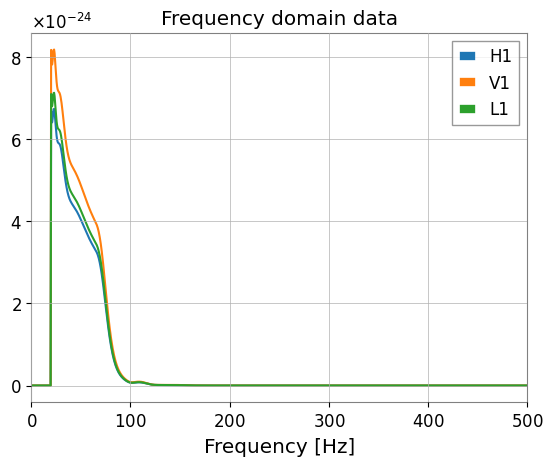

In [12]:
plt.figure()
plt.title("Frequency domain data")
for i, det in enumerate(detectors):
    plt.plot(freq_all[i], np.abs(hf_all[i]), label=det)
plt.xlim(0, 500)
plt.xlabel("Frequency [Hz]")
plt.legend()
plt.show()